In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
root = "/home/dawidkubicki/Datasets/CATS_DOGS"

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [5]:
class_names

['CAT', 'DOG']

In [6]:
len(train_data)

18743

In [7]:
len(test_data)

6251

In [8]:
for images, labels in train_loader:
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


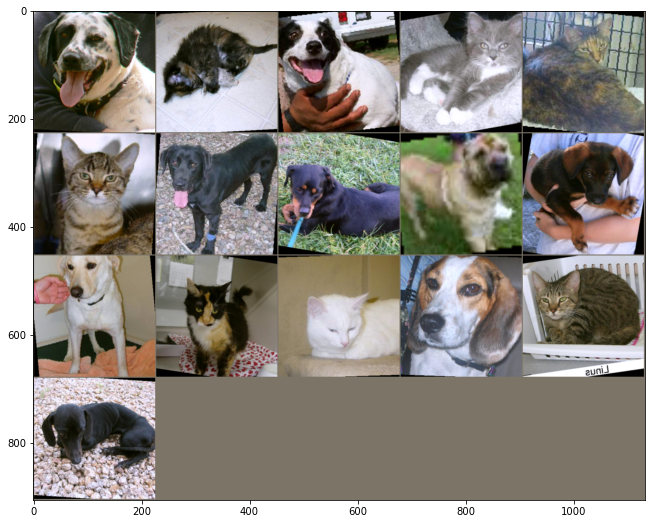

In [9]:
im = make_grid(images, nrow=5)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

im_inv = inv_normalize(im)

plt.figure(figsize=(20,9))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))

In [10]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)
        
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim=1)

In [11]:
torch.manual_seed(101)

CNNmodel = ConvolutionalNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=1e-3)

In [12]:
for param in CNNmodel.parameters():
    print(param.numel())

162
6
864
16
5598720
120
10080
84
168
2


In [13]:
import time

start_time = time.time()

EPOCHS = 5

#OPTIONAL limits on number of batches
max_trained_batch = 100 # batch has 16 images --> 12800 images
max_tested_batch = 50

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for epoch in range(EPOCHS):
    trn_correct = 0
    tst_correct = 0
    
    for batch, (X_train, y_train) in enumerate(train_loader):
        #optional limit batches
#         if batch == max_trained_batch:
#             break
            
        batch += 1
        
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred,y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_correct += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%200 == 0:
            print(f"Epoch: {epoch}, batch: {batch}, loss: {loss.item()}")

    train_losses.append(loss)
    train_correct.append(trn_correct)
    
    
    with torch.no_grad():
        
        for b, (X_test, y_test) in enumerate(test_loader):
            
            #optional limit batches
#             if b == max_trained_batch:
#                 break
            
            y_val = CNNmodel(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            batch_corr = (predicted==y_test).sum()
            tst_correct += batch_corr
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_correct)     

end_time = time.time()-start_time

print(f"Total time: {end_time/60} minutes")

Epoch: 0, batch: 200, loss: 0.6654310822486877
Epoch: 0, batch: 400, loss: 0.7083702087402344


/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/home/dawidkubicki/anaconda3/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:763: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
 

Epoch: 0, batch: 600, loss: 0.6878293752670288
Epoch: 0, batch: 800, loss: 0.40169036388397217
Epoch: 0, batch: 1000, loss: 0.5914591550827026
Epoch: 1, batch: 200, loss: 0.631620466709137
Epoch: 1, batch: 400, loss: 0.39751288294792175
Epoch: 1, batch: 600, loss: 0.4308980107307434
Epoch: 1, batch: 800, loss: 0.34531497955322266
Epoch: 1, batch: 1000, loss: 0.20720034837722778
Epoch: 2, batch: 200, loss: 0.5143648982048035
Epoch: 2, batch: 400, loss: 0.4626941978931427
Epoch: 2, batch: 600, loss: 0.663644015789032
Epoch: 2, batch: 800, loss: 0.4508132040500641
Epoch: 2, batch: 1000, loss: 0.3400708734989166
Epoch: 3, batch: 200, loss: 0.26485738158226013
Epoch: 3, batch: 400, loss: 0.17607741057872772
Epoch: 3, batch: 600, loss: 0.364335298538208
Epoch: 3, batch: 800, loss: 0.31183236837387085
Epoch: 3, batch: 1000, loss: 0.48170337080955505
Epoch: 4, batch: 200, loss: 0.5130967497825623
Epoch: 4, batch: 400, loss: 0.4376312494277954
Epoch: 4, batch: 600, loss: 0.5685149431228638
Epoc

In [15]:
torch.save(CNNmodel.state_dict(), "my5epochmode.pt")

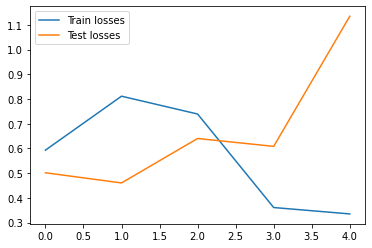

In [16]:
plt.plot(train_losses, label="Train losses")
plt.plot(test_losses, label="Test losses")
plt.legend()

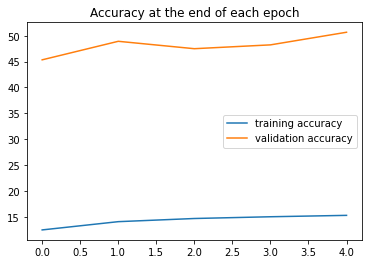

In [17]:
plt.plot([t/1000 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [18]:
num_c = test_correct[-1].item()
print(num_c*100 / 3000)

168.9
